# Imports

In [1]:
import pandas as pd
import requests
import json
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from datetime import datetime
import calendar
from scipy import stats
import sys
import time

# Functions

In [2]:
def tounixtime(datetime_input):
    return(calendar.timegm(datetime_input.utctimetuple()))

def todatetimeformat(utctime):
    year=int(utctime[0])*1000 + int(utctime[1])*100 + int(utctime[2])*10 + int(utctime[3])
    month=int(utctime[5])*10 + int(utctime[6])
    day=int(utctime[8])*10 + int(utctime[9])
    hr=int(utctime[11])*10 + int(utctime[12])
    minute=int(utctime[14])*10 + int(utctime[15])
    second=int(utctime[17])*10 + int(utctime[18])
    millisecond=int(utctime[20])*100 + int(utctime[21])*10 + int(utctime[22])   
    return(datetime(year,month,day,hr,minute,second,millisecond))

def toutcformat(datetime_input):
    tstr=str(datetime_input)
    year=tstr[0]+tstr[1]+tstr[2]+tstr[3]
    month=tstr[5]+tstr[6]
    day=tstr[8]+tstr[9]

    try:
        if type(int(tstr[11]+tstr[12]))==int:
            hour=str(tstr[11]+tstr[12])
    except:
        hour='00'             #no hours given

    try:
        if type(int(tstr[14]+tstr[15]))==int:
            minute=str(tstr[14]+tstr[15])
    except:
        minute='00'             #no minutes given

    try:
        if type(int(tstr[17]+tstr[18]))==int:
            second=str(tstr[17]+tstr[18])
    except:
        second='00'             #no seconds given

    try:
        if type(int(tstr[20]+tstr[21]+tstr[22]))==int:
            millisecond=str(tstr[20]+tstr[21]+tstr[22])
    except:
        millisecond='000'       #no milliseconds given



    utctime=year + '-' + month + '-' + day + 'T' + hour + ':' + minute + ':' + second + '.' + millisecond + 'Z'
    return utctime


def addsecutc(utctime,sec):
    return(toutcformat(datetime.utcfromtimestamp(tounixtime(todatetimeformat(utctime))+(sec))))

def addminutc(utctime,minutes):
    return(toutcformat(datetime.utcfromtimestamp(tounixtime(todatetimeformat(utctime))+(60*minutes))))

def addhrsutc(utctime,hrs):    
    return(toutcformat(datetime.utcfromtimestamp(tounixtime(todatetimeformat(utctime))+(60*60*hrs))))

def get_next_time(greater_than):
    data_url_time = "https://smartaqnet.teco.edu/v1.0/Datastreams('" + datastreamid + "')/Observations?$orderby=phenomenontime%20asc&$select=phenomenontime,result&$filter=phenomenontime%20ge%20" + greater_than + "&$top=1"
    data_time = json.loads(requests.get(data_url_time).text)["value"]
    return(data_time[0]["phenomenonTime"])


def generate_kalibrated_datastream(start_from):

    data_url = "https://smartaqnet.teco.edu/v1.0/Datastreams('" + datastreamid + "')/Observations?$orderby=phenomenontime%20asc&$select=phenomenontime,result&$filter=phenomenontime%20ge%20" + start_from + "&$top=" + str(block_size)

    data = json.loads(requests.get(data_url).text)["value"]
    starting_time = data[0]["phenomenonTime"]
    end_time = data[-1]["phenomenonTime"]

    data_array = []
    for thispiece in data: 
        data_array.append([thispiece["phenomenonTime"],thispiece["result"]])



    distr_data[starting_time + "/" + end_time] = (np.array(data_array)).T
    return(end_time)

# Parameters

In [3]:
distr_data = {} #the simulated datastream
saved_time = 0 #collects the amount of minutes saved for evaluation of the script
integrated_area=0 #area below the curve for comparison with the faster measurements
timeshift_level_list = [] #lists to plot the timeshifts
timeshift_time_list = []

datastreamid="saqn:ds:d811458"

block_size = 10 #how many datapoints should be used to determine the distribution
#block_frequency = 15 #in der simulation ja schon durch daten bestimmt ist

start_at = "2019-03-26T05:30:00.000Z"
end_at = addhrsutc(start_at,24)
time_not_met = True

#initialisation values for the distributions to compare
time_km1 = get_next_time(start_at)                  #start of block k
time_k = generate_kalibrated_datastream(time_km1)   #end of block k
time_l = get_next_time(time_k)                      #start of block l
time_lp1 = generate_kalibrated_datastream(time_l)   #end of block l

#initial settings
timeshift_level = 0
countdown = 0

#parameters
countdown_max = 5 #number of compared distributions before measuring slower
timeshift_max = 3 #timeshift stacks allowed
timeshift_length = 60 #in seconds
penalty = 2*timeshift_level #subtract from countdown if distributions dont match
ks_p_threshold = 0.1 #p-value above which the kolmogorov-smirnov test will view the distributions as equal

# Main Loop

In [4]:
#add the first block as starting value to the integrated area

distribution_at_k=distr_data[time_km1 + "/" + time_k][-1]
k_mean = np.mean(distribution_at_k.astype(np.float))
k_time = abs(tounixtime(todatetimeformat(time_k)) - tounixtime(todatetimeformat(time_km1)))

integrated_area += k_time * k_mean

benchmark_set = False


loop_start_time = tounixtime(datetime.utcnow())
x_format = 3600 #x axis steps in seconds

#main loop that fills the (simulated) datastream distr_data
while time_not_met:

    if benchmark_set == False: 
        benchmark_distribution = distr_data[time_km1 + "/" + time_k][-1]
        benchmark_set = True
        
    #calculate kolmogorov smirnov of the two distributions around k and around l
    distribution_at_k=distr_data[time_km1 + "/" + time_k][-1]
    distribution_at_l=distr_data[time_l + "/" + time_lp1][-1]
#    ks_z_score, ks_p_value = ks_2samp(distribution_at_k, distribution_at_l) #vergleiche distribution i mit i+1
    ks_z_score, ks_p_value = ks_2samp(benchmark_distribution, distribution_at_l) #p-value aus vergleich mit benchmark
    
    
    k_mean = np.mean(distribution_at_k.astype(np.float)) #first value is included in area between blocks [1:]
    l_mean = np.mean(distribution_at_l.astype(np.float)) #first value is included in area between blocks [1:]
    
    k_time = abs(tounixtime(todatetimeformat(time_k)) - tounixtime(todatetimeformat(time_km1)))
    l_time = abs(tounixtime(todatetimeformat(time_lp1)) - tounixtime(todatetimeformat(time_l)))
    
    k_to_l_time = abs(tounixtime(todatetimeformat(time_l)) - tounixtime(todatetimeformat(time_k)))
    
    
    #calculate area below the curve
    #block k
    #integrated_area +=  k_time * k_mean #comment out because it will be the l block in the next loop
    #l block
    integrated_area +=  l_time * l_mean
    # area between blocks
    integrated_area += (k_mean + l_mean) * 0.5 * k_to_l_time
    
    
    #evalute the comparison
    if ks_p_value > ks_p_threshold:
        countdown += 1
    else: 
        countdown -= penalty #current implementation: penalty instead of measure fast for validation and remember old setting
        if countdown < 1:
            countdown = 0
            timeshift_level = 0 #measure faster. measure full speed again. 
            benchmark_set = False #reset benchmark, take new one in next round

    if countdown > countdown_max: #when the countdown reaches its threshold: measure slower...
        if timeshift_level < timeshift_max: #... if timeshift_max is not yet reached  
            timeshift_level += 1 
            countdown = 0
        else:
            countdown = countdown_max #make sure it doesnt keep counting beyond max
    else: 
        pass
    
    time_jump = timeshift_length * timeshift_level #determines the pause in seconds between measuring blocks
    
    time_km1, time_k = [time_l, time_lp1] #sets the block km1...k as what was the block l...lp1 before
    
    time_l = get_next_time(addsecutc(time_k,time_jump)) #add timejump seconds to the end of period k to determine start of period l

    if  tounixtime(todatetimeformat(time_l)) > tounixtime(todatetimeformat(end_at)):
        time_not_met = False
        break
    else:
        time_lp1 = generate_kalibrated_datastream(time_l) #get measurements for the block l...lp1
        
    saved_time += timeshift_length * timeshift_level /60 #saved time in minutes
    #kann auch timeshift über der tageszeit angeben um zu sehen wann (nachts) der sensor langsamer misst
    
    sys.stdout.write("Timeshift: " + str(timeshift_level) + " Datapoints: " + str(len(distr_data)) + " From " + start_at[5:-8]  + " at " + time_lp1[5:-8]  + " of " + end_at[5:-8]  + " \r") 
    
    timeshift_level_list.append(timeshift_level)
    timeshift_time_list.append(abs(tounixtime(todatetimeformat(time_lp1)) - tounixtime(todatetimeformat(start_at)))/x_format)

loop_end_time = tounixtime(datetime.utcnow())
print("")
print("Total Time elapsed: " + str((loop_end_time-loop_start_time)/60) + "min")

Timeshift: 3 Datapoints: 385 From 03-26T05:30 at 03-27T05:27 of 03-27T05:30 
Total Time elapsed: 11.75min


## Comparison with the full data

In [5]:
def hrs_from_start(array):
    new_array = []
    for this in array:
        new_array.append((tounixtime(todatetimeformat(this)) - tounixtime(todatetimeformat(start_at)))/3600)
    return(new_array)

def time_from_start(array):
    new_array = []
    for this in array:
        new_array.append((tounixtime(todatetimeformat(this)) - tounixtime(todatetimeformat(start_at)))/x_format)
    return(new_array)

def stuff_to_float(array):
    new_array = []
    for this in array:
        new_array.append(float(this))
    return(new_array)



distr_array = np.array([])
time_array = np.array([])
for timespan in list(distr_data):
    time_array = np.concatenate((time_array, time_from_start(distr_data[timespan][0])))
    distr_array = np.concatenate((distr_array, stuff_to_float(distr_data[timespan][-1])))

    
full_data_link = "https://smartaqnet.teco.edu/v1.0/Datastreams('" + datastreamid + "')/Observations?$filter=Overlaps(phenomenontime,"+ start_at +"/" + end_at + ")&$orderby=phenomenontime%20asc&$count=true"
real_data_count = json.loads(requests.get(full_data_link).text)["@iot.count"]
real_data_list = json.loads(requests.get(full_data_link + "&$select=phenomenontime,result&$orderby=phenomenontime%20asc&$top=" + str(real_data_count)).text)["value"] 


#calculate area below the curve 
full_data_area=0
for i in range(1,len(real_data_list)):
    full_data_area += real_data_list[i]["result"] * abs(tounixtime(todatetimeformat(real_data_list[i]["phenomenonTime"])) - tounixtime(todatetimeformat(real_data_list[i-1]["phenomenonTime"])))


#generate time axis for plotting    
real_data_array = []
real_data_time_array = []
for thiselement in list(real_data_list):
    real_data_time_array.append((tounixtime(todatetimeformat(thiselement["phenomenonTime"])) - tounixtime(todatetimeformat(start_at)))/x_format)
    real_data_array.append(float(thiselement["result"]))    

# Evaluation

In [6]:
print("--------------------------------------------------")
print("Integrated area of reduced data: " + str(round(integrated_area/1000,2)))
print("Integrated area of full data: " + str(round(full_data_area/1000,2)))
print("ratio: " + str(round(integrated_area/full_data_area,3)*100) + "%")
print("--------------------------------------------------")
print("Number of Measurements in reduced data: " + str(len(distr_array)))
print("Number of Measurements in full data: " + str(len(real_data_array)))
print("ratio: " + str(round(len(distr_array)/len(real_data_array),1)))
print("--------------------------------------------------")
print("Amount of Minutes of downtime: " + str(saved_time))
print("Time saving: " + str(round(saved_time/((tounixtime(todatetimeformat(end_at)) - tounixtime(todatetimeformat(start_at)))/60),3)*100) + "%")

--------------------------------------------------
Integrated area of reduced data: 788.55
Integrated area of full data: 786.42
ratio: 100.29999999999998%
--------------------------------------------------
Number of Measurements in reduced data: 3850
Number of Measurements in full data: 8469
ratio: 0.5
--------------------------------------------------
Amount of Minutes of downtime: 835.0
Time saving: 57.99999999999999%


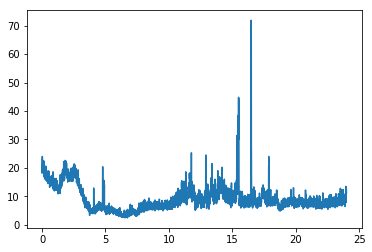

In [7]:
plt.plot(real_data_time_array, real_data_array, drawstyle='steps-pre') 

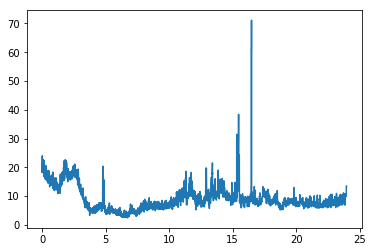

In [8]:
plt.plot(time_array, distr_array, drawstyle='steps-pre')

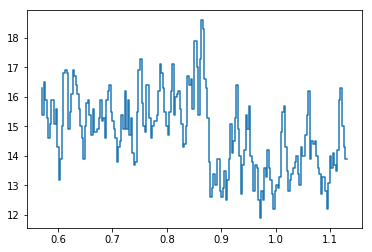

In [16]:
plt.plot(real_data_time_array[200:400], real_data_array[200:400], drawstyle='steps-pre')

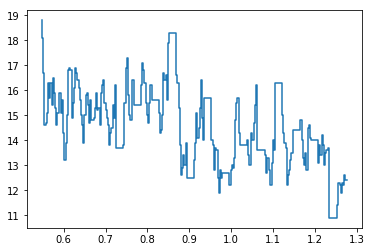

In [17]:
plt.plot(time_array[200:400], distr_array[200:400], drawstyle='steps-pre')

In [9]:
# def get_fitting_index(i):
#     value_to_match = real_data_time_array[i]
#     for j in range(len(time_array)):
#         if time_array[j] > value_to_match:
#             ind=j
#             break
#     return(ind)

# start_index = 1
# end_index = len(real_data_time_array)-10

# area_real = 0
# area_reduced = 0

# for k in range(start_index, end_index-1):
#     area_real += (real_data_time_array[k+1] - real_data_time_array[k]) * real_data_array[k]

# for k in range(get_fitting_index(start_index), get_fitting_index(end_index)-1):
#     area_reduced += (time_array[k+1] - time_array[k]) * distr_array[k]
    
# print("Full area: " + str(area_real*x_format/1000))
# print("Calculated area: " + str(area_reduced*x_format/1000))
    


In [10]:
plt.plot(time_array[get_fitting_index(start_index):get_fitting_index(end_index)], distr_array[get_fitting_index(start_index):get_fitting_index(end_index)], drawstyle='steps-pre')

NameError: name 'get_fitting_index' is not defined

In [ ]:
plt.plot(real_data_time_array[start_index:end_index], real_data_array[start_index:end_index], drawstyle='steps-pre')

In [ ]:
plt.plot(timeshift_time_list, timeshift_level_list, drawstyle='steps-post')

In [ ]:
# res_x = []
# res_y = []
# for j in range(5,len(time_array)):
    
# #     test_time = time_array[0:j]
# #     test_val = distr_array[0:j]
    
#     test_val = np.random.randn(j)+10
#     test_time = range(len(test_val))

#     area_mean=np.mean(test_val[1:]) * (test_time[-1] - test_time[0])

#     area = []
#     for i in range(1,len(test_val)):
#         area.append(test_val[i] * (test_time[i] - test_time[i-1]))


#     res_x.append(j)
#     res_y.append(round(area_mean/sum(area)*100,1))

# print(area_mean/1000)
# print(sum(area)/1000)
# plt.plot(res_x,res_y)

In [ ]:
# test_total_area = 0
# len(list(distr_data))
# for i in range(1,2):
#     test_array_k = distr_data[list(distr_data)[i-1]]
#     test_mean_k = np.mean(stuff_to_float(test_array_k[1]))
#     test_start_k = tounixtime(todatetimeformat(test_array_k[0][0]))
#     test_end_k = tounixtime(todatetimeformat(test_array_k[0][-1]))
#     test_area_k = (test_end_k - test_start_k) * test_mean_k

#     test_array_l = distr_data[list(distr_data)[i]]
#     test_mean_l = np.mean(stuff_to_float(test_array_l[1]))
#     test_start_l = tounixtime(todatetimeformat(test_array_l[0][0]))
#     test_end_l = tounixtime(todatetimeformat(test_array_l[0][-1]))
#     test_area_l = (test_end_l - test_start_l) * test_mean_l
    
#     test_total_area += test_area_k
#     test_total_area += test_area_l
#     test_total_area += (test_mean_k + test_mean_l) * 0.5 * (test_start_l - test_end_k)
    
#     time.sleep(.01)
    
#     sys.stdout.write("Area: " + str(round(test_total_area,1)) + " \r") 


In [ ]:
# test_total_area = 0
# #len(list(real_data_list))
# for i in range(1,10):
#     test_mean_k = real_data_list[i]["result"]
#     test_start_k = tounixtime(todatetimeformat(real_data_list[i-1]["phenomenonTime"]))
#     test_end_k = tounixtime(todatetimeformat(real_data_list[i]["phenomenonTime"]))
#     test_area_k = (test_end_k - test_start_k) * test_mean_k
    
#     test_total_area += test_area_k

    
#     time.sleep(.002)
    
#     sys.stdout.write("Area: " + str(round(test_total_area,1)) + " \r") 
